In [1]:
import QUANTAXIS as QA
import sys

if QA.__version__<'1.1.3':
    print('请先升级QUANTAXIS至1.1.3来使用此教程 pip install quantaxis==1.1.3 或者git pull')
    sys.exit()

QUANTAXIS>> start QUANTAXIS
QUANTAXIS>> Welcome to QUANTAXIS, the Version is 1.1.2
QUANTAXIS>>  
 ```````````````````````````````````````````````````````````````````````````````````````````````````````````````````````` 
  ``########`````##````````##``````````##`````````####````````##```##########````````#``````##``````###```##`````######`` 
  `##``````## ```##````````##`````````####````````##`##```````##```````##```````````###``````##````##`````##```##`````##` 
  ##````````##```##````````##````````##`##````````##``##``````##```````##``````````####```````#```##``````##```##``````## 
  ##````````##```##````````##```````##```##```````##```##`````##```````##`````````##`##```````##`##```````##````##``````` 
  ##````````##```##````````##``````##`````##``````##````##````##```````##````````##``###```````###````````##`````##`````` 
  ##````````##```##````````##``````##``````##`````##`````##```##```````##```````##````##```````###````````##``````###```` 
  ##````````##```##````````##`````##``````

In [2]:
Account=QA.QA_Account(allow_sellopen=True,allow_t0=True,account_cookie='future_test',market_type=QA.MARKET_TYPE.FUTURE_CN,frequence=QA.FREQUENCE.FIFTEEN_MIN)

In [3]:
Broker=QA.QA_BacktestBroker()

In [4]:
rb=QA.QA_fetch_get_future_min('tdx','RBL8','2018-01-01','2018-08-28',frequence='15min')

QUANTAXIS>> Selecting the Best Server IP of TDX


USING DEFAULT STOCK IP
USING DEFAULT FUTURE IP


QUANTAXIS>> === The BEST SERVER ===
 stock_ip 60.191.117.167 future_ip 112.74.214.43


In [5]:
rb_ds=QA.QA_DataStruct_Future_min(rb.set_index(['datetime','code']))

In [6]:
import numpy as np
import pandas as pd
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})

ind=rb_ds.add_func(MACD_JCSC)


In [7]:
_date = None
for items in rb_ds.panel_gen:
    if _date != items.date[0]:
        print('try to settle')
        _date=items.date[0]
        Account.settle()
    
    
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_JC.iloc[0]>0:
            order=Account.send_order(
                code=item.code[0], 
                time=item.date[0], 
                amount=200, 
                towards=QA.ORDER_DIRECTION.BUY, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )

            if order:
                print(order)
                print(item)
                Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                res=trade_mes.loc[order.account_cookie,order.realorder_id]
                order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
        elif daily_ind.CROSS_SC.iloc[0]>0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order=Account.send_order(
                    code=item.code[0], 
                    time=item.date[0], 
                    amount=Account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                if order:
                    Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                    trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                    res=trade_mes.loc[order.account_cookie,order.realorder_id]
                    order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    Account.settle()
            

try to settle
try to settle
try to settle
try to settle
< QA_Order realorder_id Order_T0Gba56y datetime:2018-03-08 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_T0Gba56y account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
receive deal
try to settle
< QA_Order realorder_id Order_Dx8BcSRA datetime:2018-03-09 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_Dx8BcSRA account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
receive deal
< QA_Order realorder_id Order_LxAVEJSa datetime:2018-03-09 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_LxAVEJSa account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
try to settle
receive deal
try to settle
< QA_Order realorder_id Order_QuDL1FNC datetime:2018-03-14 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_

< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
receive deal
try to settle
< QA_Order realorder_id Order_hQbPGyr4 datetime:2018-04-27 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_hQbPGyr4 account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
< QA_Order realorder_id Order_mg0aVdBk datetime:2018-04-27 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_mg0aVdBk account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
238796.10000000044
NOT ENOUGH MONEY FOR Order_mg0aVdBk
try to settle
try to settle
receive deal
try to settle
< QA_Order realorder_id Order_snDUjqFL datetime:2018-05-04 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_snDUjqFL account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
receive deal
< QA_Order realorder_id Order_cbaeQh8y datetime

< QA_Order realorder_id Order_IfV5ieNO datetime:2018-06-12 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_IfV5ieNO account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
receive deal
< QA_Order realorder_id Order_WE3PI4DY datetime:2018-06-13 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_WE3PI4DY account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
receive deal
try to settle
< QA_Order realorder_id Order_ysa09mWh datetime:2018-06-14 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_ysa09mWh account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
receive deal
< QA_Order realorder_id Order_QV1X9ch3 datetime:2018-06-14 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_QV1X9ch3 account:future_test status:queued >
< QA_DataStruct_Futur

NOT ENOUGH MONEY FOR Order_LQ52ngIw
receive deal
try to settle
try to settle
try to settle
< QA_Order realorder_id Order_pGrNM07C datetime:2018-07-31 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_pGrNM07C account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
receive deal
try to settle
< QA_Order realorder_id Order_moE7MUiw datetime:2018-08-01 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_moE7MUiw account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
receive deal
< QA_Order realorder_id Order_coXxbPNw datetime:2018-08-01 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn order_id:Order_coXxbPNw account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
< QA_Order realorder_id Order_2qEkC6GJ datetime:2018-08-02 09:31:00 code:RBL8 amount:200 price:0 towards:1 btype:future_cn ord

In [8]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax
0,2018-03-08 10:15:00,RBL8,3873.0,200,225206.350,Order_T0Gba56y,Order_T0Gba56y,Trade_Ax0MrCpG,future_test,193.650,0
1,2018-03-08 13:45:00,RBL8,3841.0,-200,993214.300,Order_Ze1nh8k9,Order_Ze1nh8k9,Trade_qpGJYO5I,future_test,192.050,0
2,2018-03-09 09:15:00,RBL8,3791.0,200,234824.750,Order_Dx8BcSRA,Order_Dx8BcSRA,Trade_yegE6lG4,future_test,189.550,0
3,2018-03-09 10:15:00,RBL8,3747.0,-200,984037.400,Order_s2bQBXNa,Order_s2bQBXNa,Trade_s2Q9BUCb,future_test,187.350,0
4,2018-03-09 15:00:00,RBL8,3709.0,200,242051.950,Order_LxAVEJSa,Order_LxAVEJSa,Trade_H4EvbY5q,future_test,185.450,0
5,2018-03-13 11:15:00,RBL8,3714.0,-200,984666.250,Order_3bHxcRsF,Order_3bHxcRsF,Trade_ZKkmDMqf,future_test,185.700,0
6,2018-03-14 11:15:00,RBL8,3722.0,200,240080.150,Order_QuDL1FNC,Order_QuDL1FNC,Trade_RVigKmjs,future_test,186.100,0
7,2018-03-15 09:15:00,RBL8,3740.0,-200,987893.150,Order_bwGV692y,Order_bwGV692y,Trade_3I56bwjY,future_test,187.000,0
8,2018-03-15 14:30:00,RBL8,3753.0,200,237105.500,Order_mDigqe8G,Order_mDigqe8G,Trade_hWI9zevT,future_test,187.650,0
9,2018-03-16 14:30:00,RBL8,3734.5,-200,983818.775,Order_yHpvXNCb,Order_yHpvXNCb,Trade_9DkFLAcI,future_test,186.725,0


In [10]:
rb_day=QA.QA_fetch_get_future_day('tdx','RBL8','2018-01-01','2018-08-28')
rb_dayds=QA.QA_DataStruct_Future_day(rb_day.set_index(['date','code']))

In [11]:
Risk=QA.QA_Risk(Account,if_fq=False,market_data=rb_dayds)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

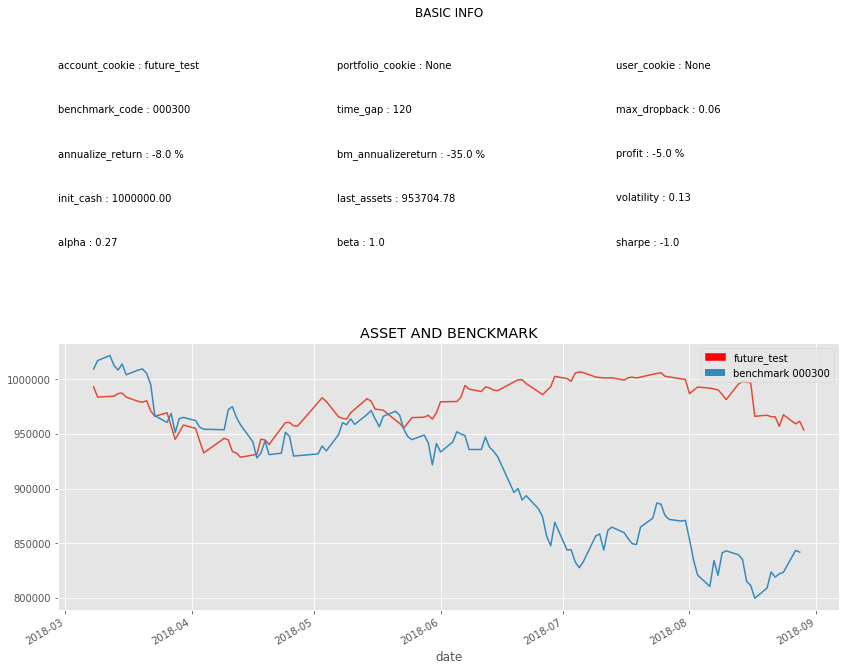

In [12]:
Risk.plot_assets_curve()